# Empirical mode decomposition

**Datasets** : CWRU bearing vibration data (Normal_0 vs IR007_0)


## EMD 1 IMF

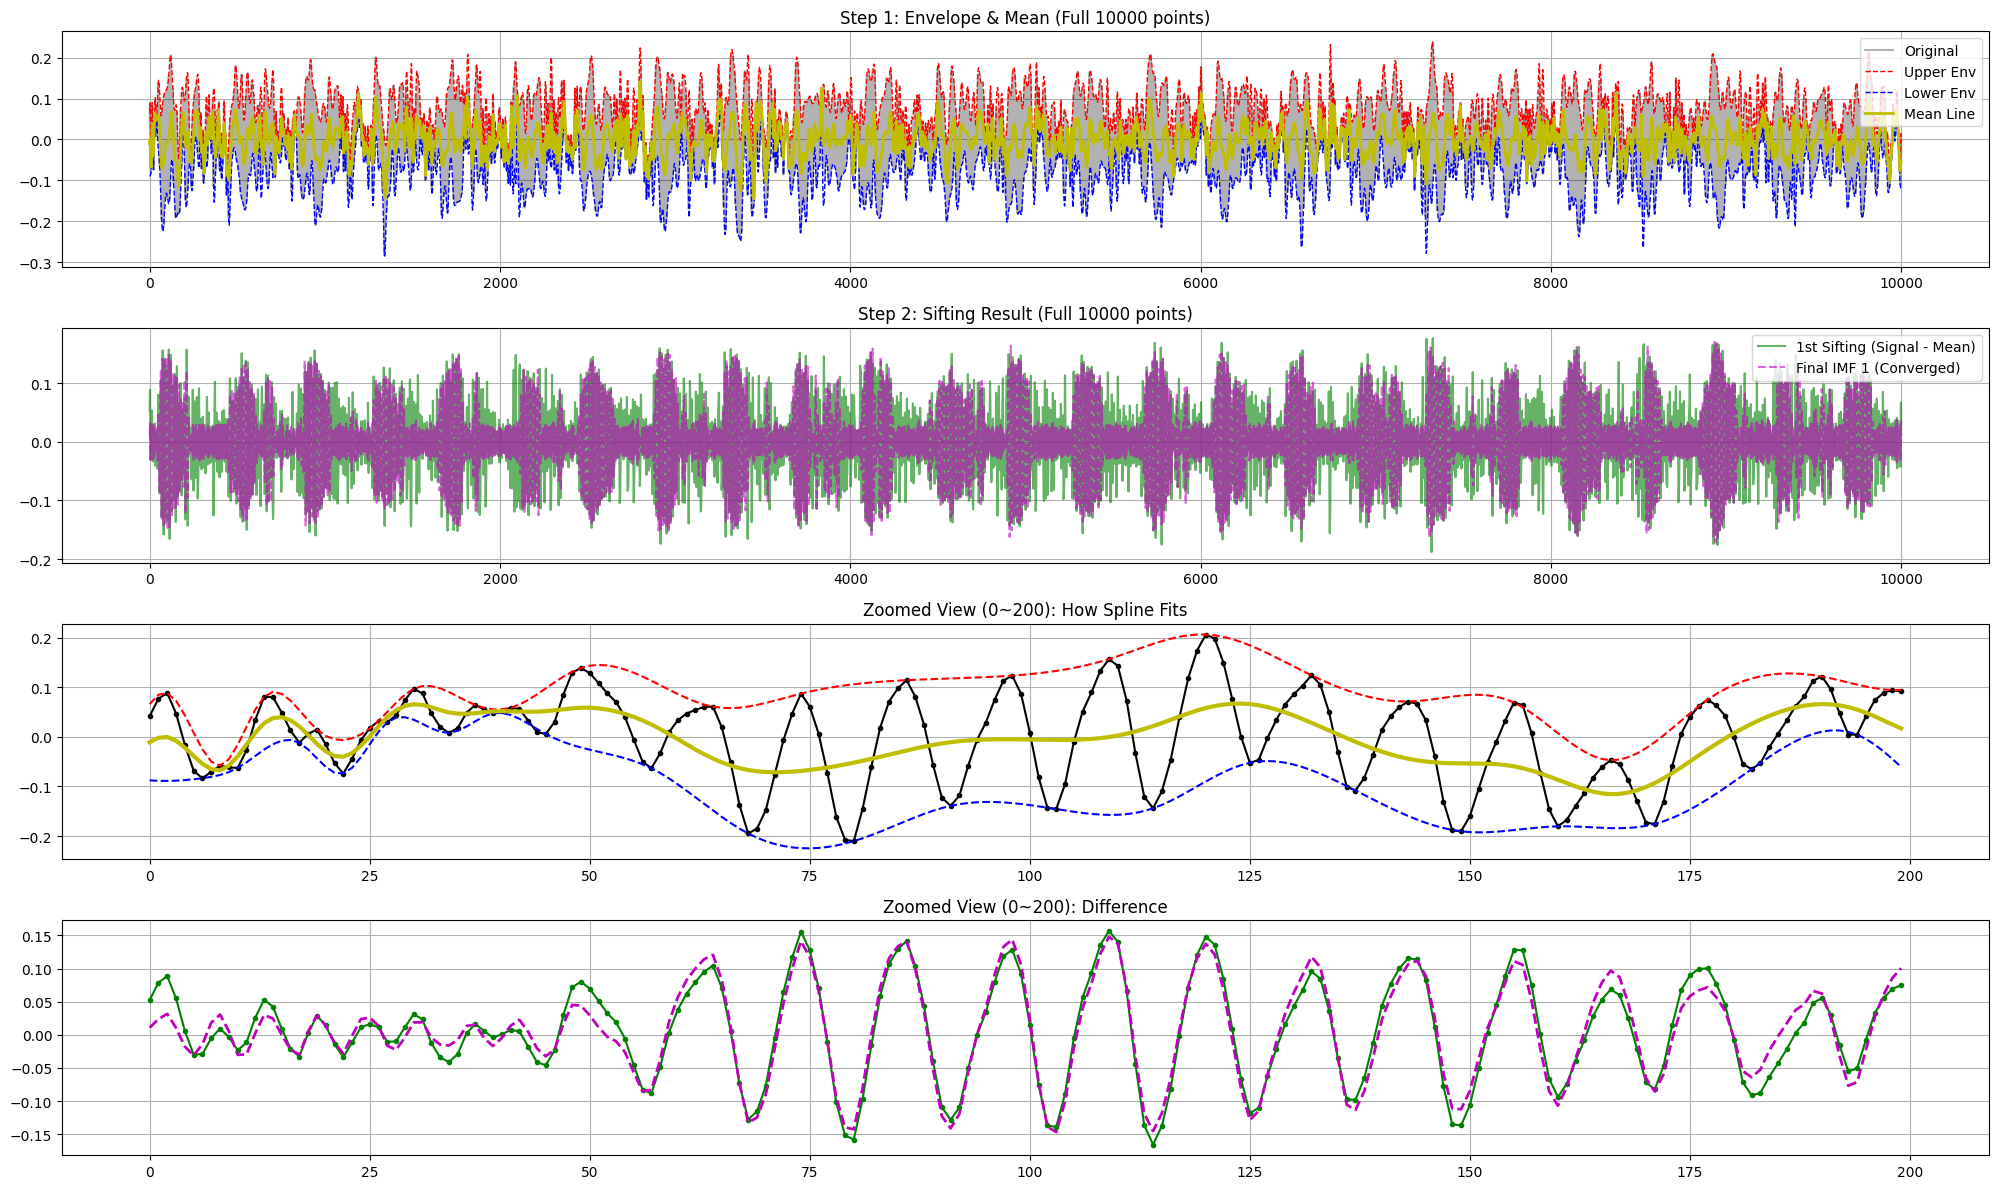

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PyEMD import EMD

# 설정
PATH_NORMAL = 'datasets/cwru/Normal_0.mat'
DATA_LEN = 10000   # 사용자 요청: 10,000개 데이터 사용

def visualize_sifting_10k(file_path):
    # 1. 데이터 로드 (정상 데이터)
    try:
        mat = loadmat(file_path)
        key = [k for k in mat.keys() if 'DE_time' in k][0]
        full_signal = mat[key].flatten()
    except Exception as e:
        print("데이터 로드 실패:", e)
        return

    # 2. 10,000개 구간 자르기 & DC 제거
    signal = full_signal[:DATA_LEN].astype(np.float64)
    signal = signal - np.mean(signal)
    
    t = np.arange(len(signal))
    
    # 3. EMD 내부 로직 수행
    emd = EMD()
    
    # --- [과정 1] 스플라인 포락선 & 평균선 계산 ---
    # 10,000개 전체에 대해 스플라인 계산
    T_norm = emd._normalize_time(t)
    max_env, min_env, _, _ = emd.extract_max_min_spline(T_norm, signal)
    
    mean_line = (max_env + min_env) / 2
    
    # --- [과정 2] 1차 Sifting (Proto-IMF) ---
    proto_imf = signal - mean_line
    
    # --- [과정 3] 최종 IMF (비교용) ---
    # 실제 EMD를 돌려서 수렴된 IMF 1번 추출
    true_imfs = emd.emd(signal, max_imf=1)
    final_imf1 = true_imfs[0]
    
    # ---------------- 시각화 ----------------
    fig, axes = plt.subplots(4, 1, figsize=(20, 12))
    
    # [왼쪽] 전체 10,000개 구간 (Overview)
    # 1. 포락선과 평균선
    ax1 = axes[0]
    ax1.plot(t, signal, 'k', alpha=0.3, label='Original')
    ax1.plot(t, max_env, 'r--', linewidth=1, label='Upper Env')
    ax1.plot(t, min_env, 'b--', linewidth=1, label='Lower Env')
    ax1.plot(t, mean_line, 'y', linewidth=2, label='Mean Line')
    ax1.set_title(f"Step 1: Envelope & Mean (Full {DATA_LEN} points)")
    ax1.legend(loc='upper right')
    ax1.grid(True)
    
    # 2. Sifting 결과
    ax2 = axes[1]
    ax2.plot(t, proto_imf, 'g', alpha=0.6, label='1st Sifting (Signal - Mean)')
    ax2.plot(t, final_imf1, 'm--', alpha=0.6, label='Final IMF 1 (Converged)')
    ax2.set_title(f"Step 2: Sifting Result (Full {DATA_LEN} points)")
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    # [오른쪽] 상세 확대 (Zoom: 0~200) - 디테일 확인용
    zoom_slice = slice(0, 200)
    t_zoom = t[zoom_slice]
    
    # 3. 포락선 상세
    ax3 = axes[2]
    ax3.plot(t_zoom, signal[zoom_slice], 'k.-', label='Original')
    ax3.plot(t_zoom, max_env[zoom_slice], 'r--', label='Upper Env')
    ax3.plot(t_zoom, min_env[zoom_slice], 'b--', label='Lower Env')
    ax3.plot(t_zoom, mean_line[zoom_slice], 'y-', linewidth=3, label='Mean Line')
    ax3.set_title("Zoomed View (0~200): How Spline Fits")
    ax3.grid(True)
    
    # 4. Sifting 상세
    ax4 = axes[3]
    ax4.plot(t_zoom, proto_imf[zoom_slice], 'g.-', label='1st Sifting')
    ax4.plot(t_zoom, final_imf1[zoom_slice], 'm--', linewidth=2, label='Final IMF 1')
    ax4.set_title("Zoomed View (0~200): Difference")
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# 실행
visualize_sifting_10k(PATH_NORMAL)

## Apply EMD

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import kurtosis
from PyEMD import EMD
import os

# 설정
CHUNK_SIZE = 10000  # 분석 윈도우 크기
PATH_NORMAL = 'datasets/cwru/Normal_0.mat'  # 정상 데이터
PATH_FAULT = 'datasets/cwru/IR007_0.mat'    # 내륜 결함(Inner Race) 0.007인치

def load_cwru_data(file_path):
    """
    .mat 파일을 읽어서 진동 데이터 배열을 반환하는 함수
    CWRU 데이터셋은 파일마다 키 이름(예: X097_DE_time, X105_DE_time)이 다르므로
    자동으로 'DE_time'이 포함된 키를 찾습니다.
    """
    try:
        mat_dict = loadmat(file_path)
        
        # 1. 데이터 키 찾기 (DE_time: Drive End 가속도 센서 데이터)
        target_key = None
        for key in mat_dict.keys():
            if 'DE_time' in key:
                target_key = key
                break
        
        # 만약 DE_time이 없으면, 가장 긴 데이터 배열을 선택 (Fallback)
        if target_key is None:
            for key, val in mat_dict.items():
                if isinstance(val, np.ndarray) and len(val) > 10000:
                    target_key = key
                    break
                    
        if target_key is None:
            print(f"Error: {file_path}에서 진동 데이터를 찾을 수 없습니다.")
            return None

        print(f"[{file_path}] Key Found: {target_key}")
        
        # 2. 데이터 추출 및 전처리
        signal = mat_dict[target_key].flatten() # 1차원 배열로 변환
        signal = signal - np.mean(signal)       # DC Offset 제거 (필수)
        
        return signal

    except Exception as e:
        print(f"파일 로드 중 에러: {e}")
        return None

print("CWRU 데이터 로더 정의 완료.")

CWRU 데이터 로더 정의 완료.


[datasets/cwru/Normal_0.mat] Key Found: X097_DE_time
[Normal Bearing] EMD 전성분 분해 시작... (시간이 조금 걸릴 수 있습니다)


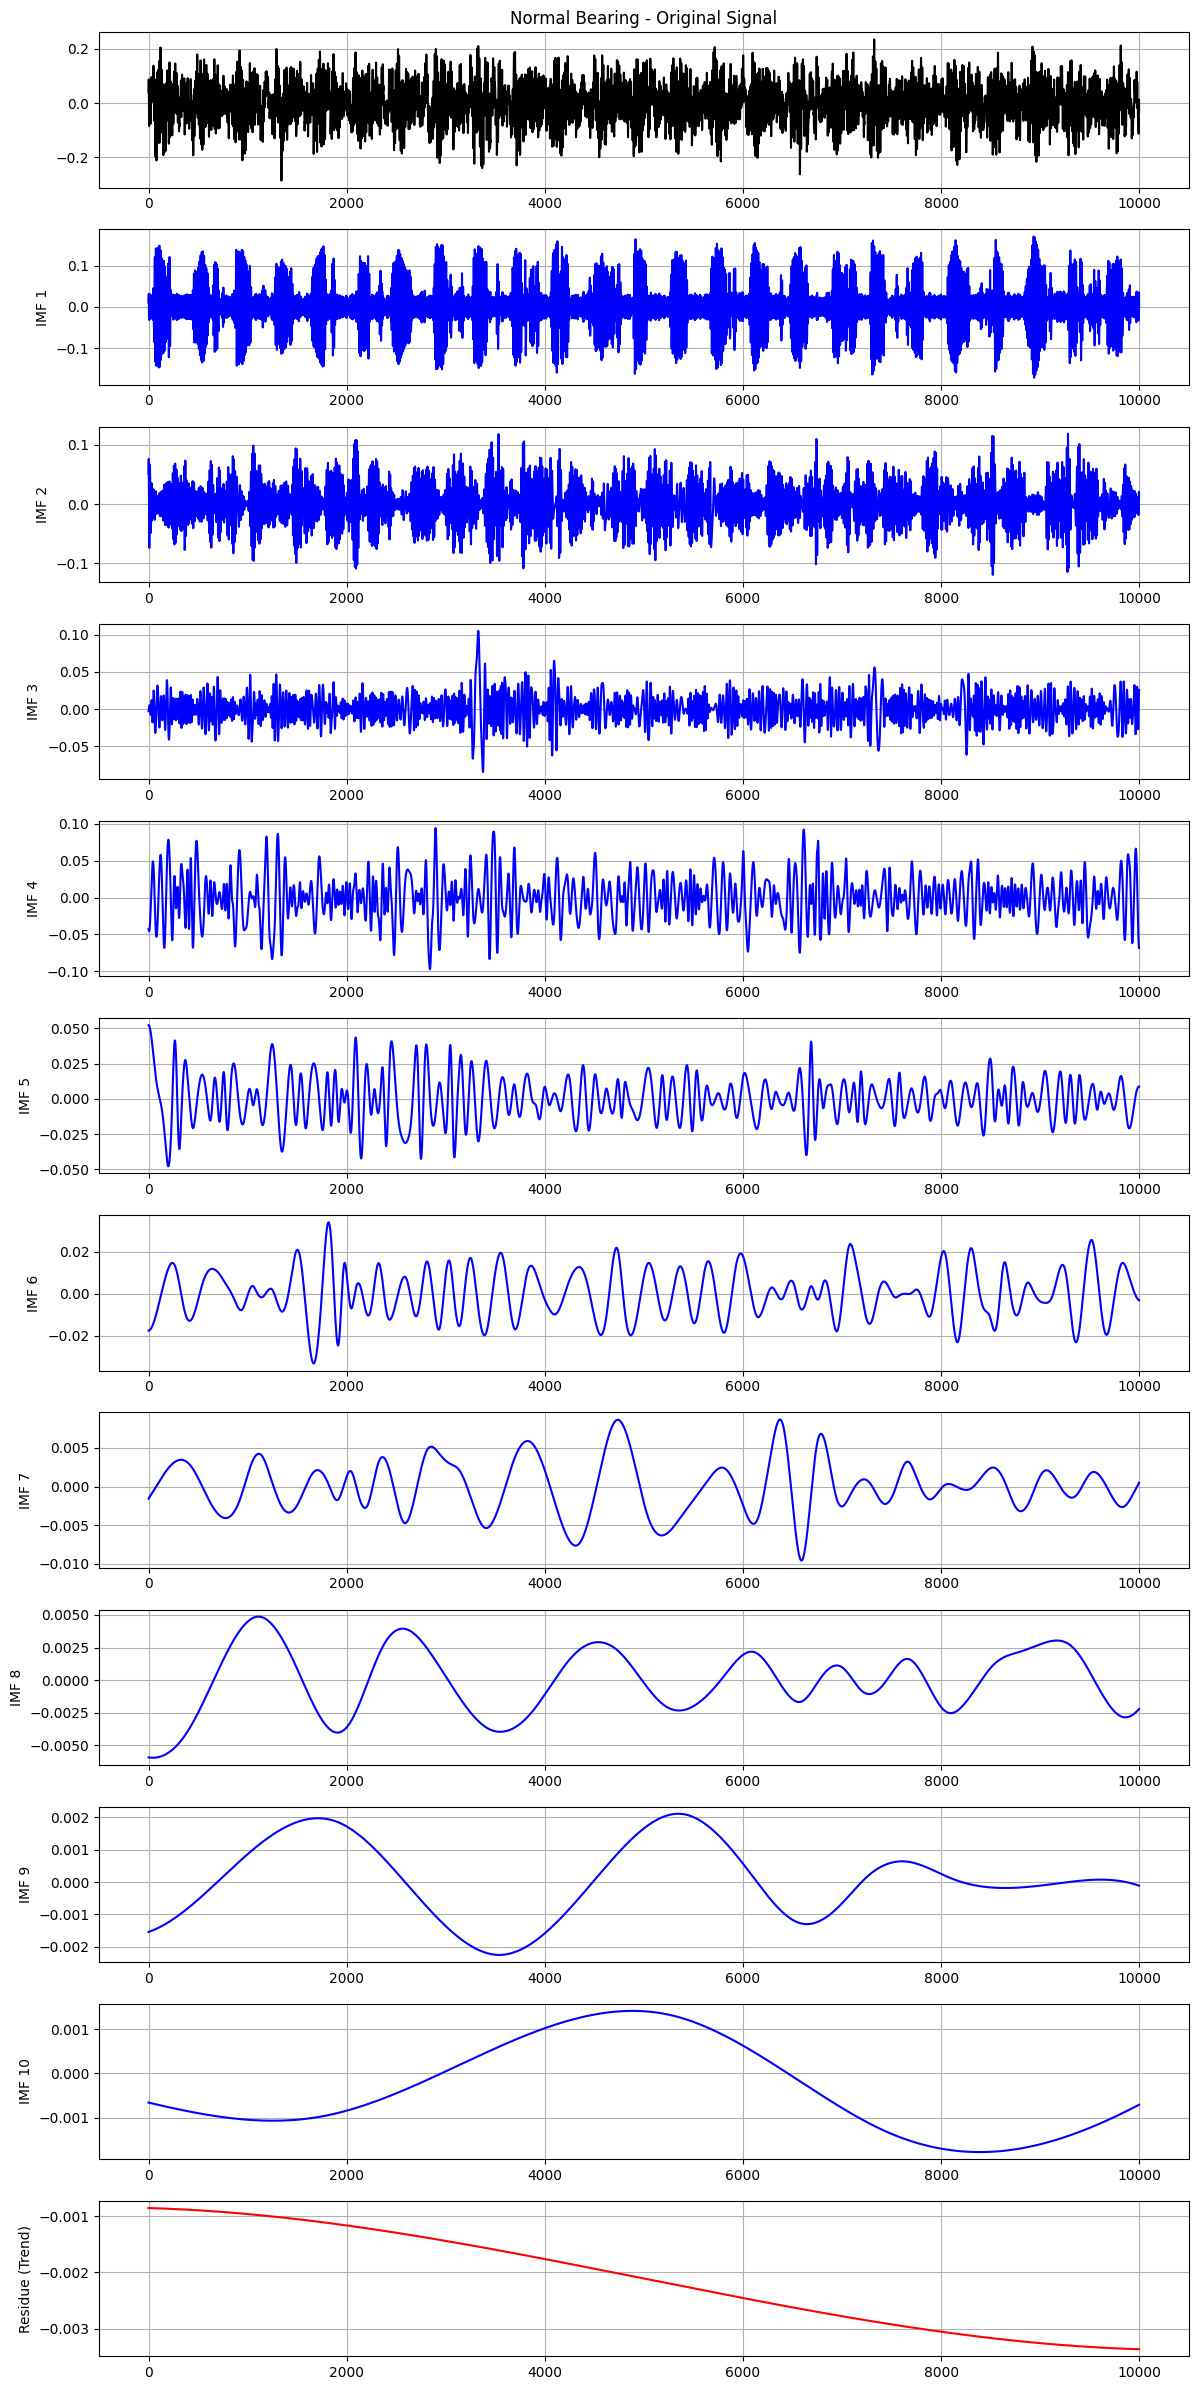

-> 총 10개의 IMF와 1개의 Residue가 추출되었습니다.

[datasets/cwru/IR007_0.mat] Key Found: X105_DE_time
[Inner Race Fault (0.007)] EMD 전성분 분해 시작... (시간이 조금 걸릴 수 있습니다)


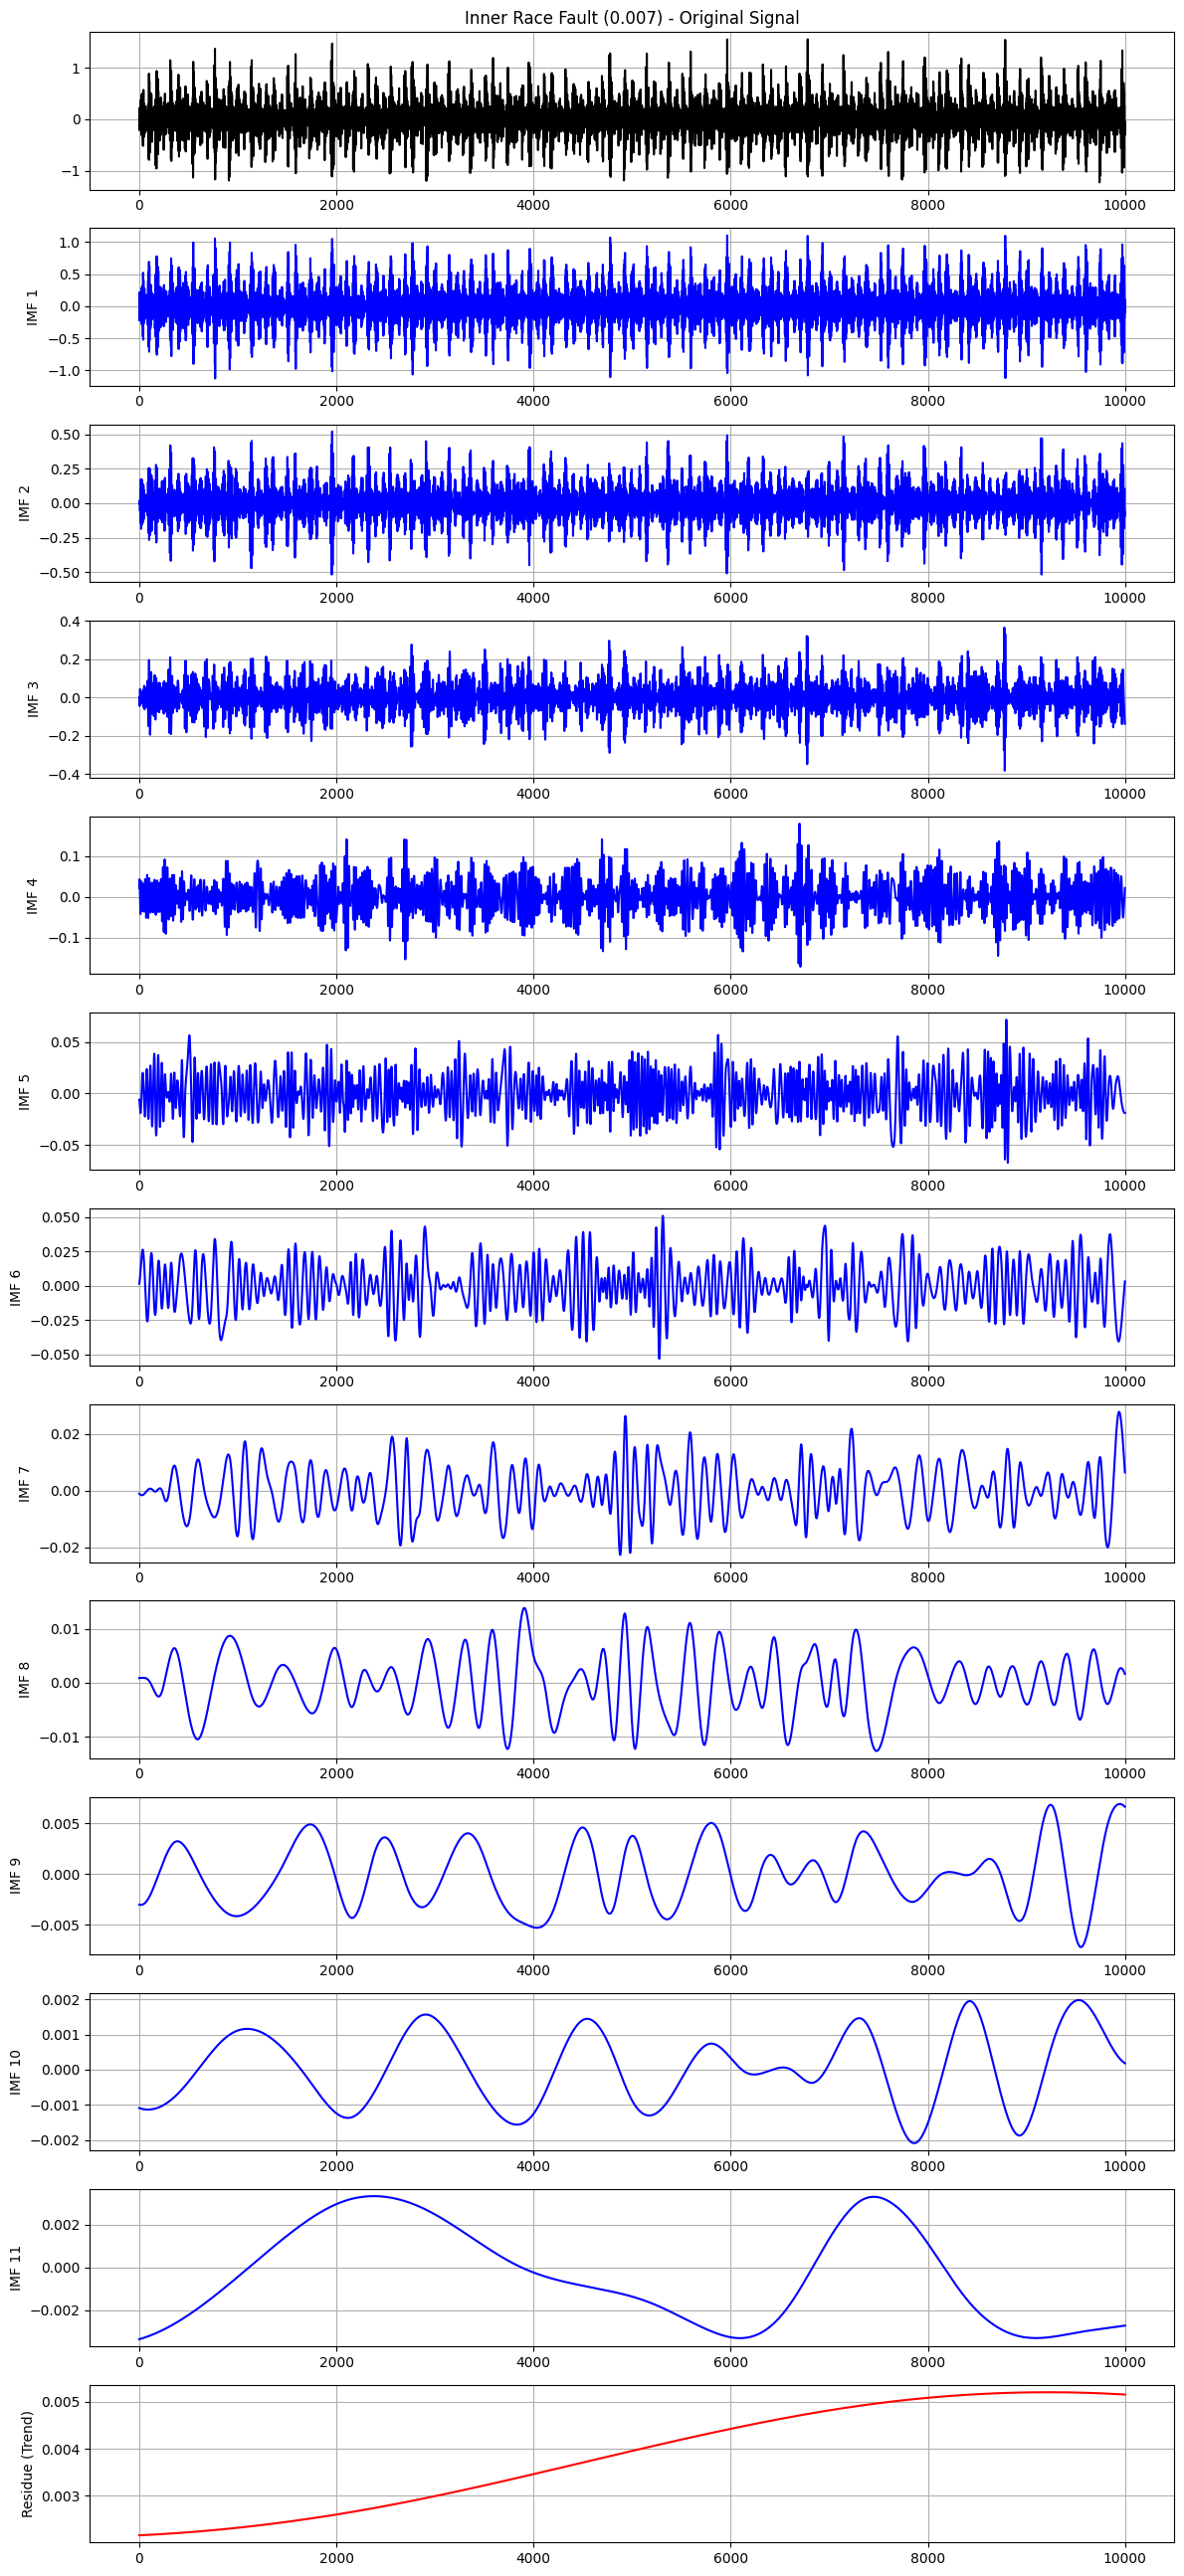

-> 총 11개의 IMF와 1개의 Residue가 추출되었습니다.



In [4]:
def run_full_emd_all_imfs(file_path, title):
    """
    제한 없이(max_imf 제거) 끝까지 분해하여 모든 IMF와 Residue를 시각화
    """
    # 1. 데이터 로드 (위에서 정의한 load_cwru_data 함수 사용)
    full_signal = load_cwru_data(file_path)
    if full_signal is None: return
    
    # 분석 구간 (4096개)
    signal = full_signal[:CHUNK_SIZE]
    t = np.arange(len(signal))
    
    print(f"[{title}] EMD 전성분 분해 시작... (시간이 조금 걸릴 수 있습니다)")
    
    # 2. EMD 수행 (제한 없음)
    emd = EMD()
    # emd.FIXE = 10 # 속도를 위해 Sifting 횟수만 고정 (정밀도 원하면 주석 처리)
    
    # max_imf 인자를 넣지 않으면 끝까지 분해합니다.
    imfs = emd.emd(signal) 
    
    # 3. 전체 시각화
    num_imfs = imfs.shape[0] # 추출된 총 IMF 개수 (마지막은 Residue)
    
    # 그래프 크기 자동 조절 (IMF 개수에 따라 길어짐)
    plt.figure(figsize=(12, 2 * (num_imfs + 1)))
    
    # 원본 신호
    plt.subplot(num_imfs + 1, 1, 1)
    plt.plot(t, signal, 'k')
    plt.title(f"{title} - Original Signal")
    plt.grid(True)
    
    # 모든 IMF 및 Residue 출력
    for i in range(num_imfs):
        plt.subplot(num_imfs + 1, 1, i + 2)
        
        # 마지막 성분은 Residue(잔차)라고 부릅니다.
        if i == num_imfs - 1:
            label = "Residue (Trend)"
            color = 'r' # 잔차는 빨간색
        else:
            label = f"IMF {i+1}"
            color = 'b' # IMF는 파란색
            
        plt.plot(t, imfs[i], color)
        plt.ylabel(label)
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()
    print(f"-> 총 {num_imfs-1}개의 IMF와 1개의 Residue가 추출되었습니다.\n")

# --- 실행 ---

# 1. 정상 데이터 전체 분해
run_full_emd_all_imfs(PATH_NORMAL, "Normal Bearing")

# 2. 결함 데이터 전체 분해
run_full_emd_all_imfs(PATH_FAULT, "Inner Race Fault (0.007)")

[datasets/cwru/Normal_0.mat] Key Found: X097_DE_time
[Normal] 특징 추출 시작 (30개 구간)...
[datasets/cwru/IR007_0.mat] Key Found: X105_DE_time
[Inner Race Fault] 특징 추출 시작 (30개 구간)...


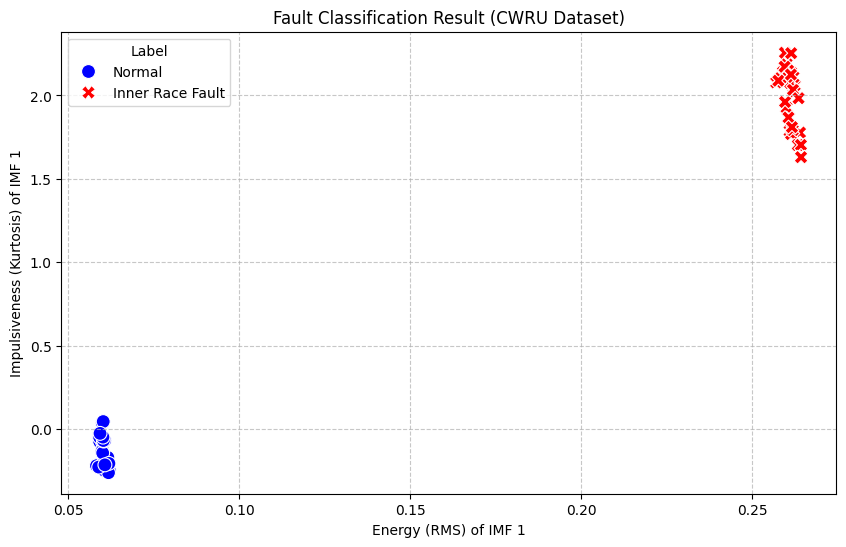

In [5]:
def extract_features_from_mat(file_path, label, num_samples=50):
    """
    .mat 데이터에서 여러 구간을 랜덤하게 잘라 특징(RMS, Kurtosis)을 추출
    """
    full_signal = load_cwru_data(file_path)
    if full_signal is None: return []
    
    features = []
    max_start_idx = len(full_signal) - CHUNK_SIZE
    
    # 랜덤하게 50개 구간 샘플링
    np.random.seed(42) # 결과 재현을 위해 시드 고정
    start_indices = np.random.randint(0, max_start_idx, num_samples)
    
    emd = EMD()
    emd.FIXE = 5 # 속도 최적화
    
    print(f"[{label}] 특징 추출 시작 ({num_samples}개 구간)...")
    
    for start in start_indices:
        # 구간 자르기
        segment = full_signal[start : start + CHUNK_SIZE]
        
        # EMD 수행 (IMF 1만 필요하므로 max_imf=1로 제한하여 속도 향상)
        imfs = emd.emd(segment, max_imf=1)
        if len(imfs) < 1: continue
            
        imf1 = imfs[0]
        
        # 특징 계산
        rms = np.sqrt(np.mean(imf1**2))
        kurt = kurtosis(imf1)
        
        features.append([rms, kurt, label])
        
    return features

# --- 실행 ---
# 1. 특징 데이터 수집
feats_normal = extract_features_from_mat(PATH_NORMAL, 'Normal', num_samples=30)
feats_fault = extract_features_from_mat(PATH_FAULT, 'Inner Race Fault', num_samples=30)

# 2. 데이터프레임 변환
df = pd.DataFrame(feats_normal + feats_fault, columns=['IMF1_RMS', 'IMF1_Kurtosis', 'Label'])

# 3. 산점도 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='IMF1_RMS', y='IMF1_Kurtosis', hue='Label', style='Label', s=100, palette=['blue', 'red'])

plt.title('Fault Classification Result (CWRU Dataset)')
plt.xlabel('Energy (RMS) of IMF 1')
plt.ylabel('Impulsiveness (Kurtosis) of IMF 1')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()